In [15]:
%pip install seaborn
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')
import json
import time
from datetime import datetime

In [16]:
# Улучшенный парсер для ЦИАН (с обработкой ошибок)
class CianParser:
    def __init__(self):
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
            'Accept-Encoding': 'gzip, deflate, br',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
        }
        self.session = requests.Session()
        self.session.headers.update(self.headers)
    
    def parse_page_safe(self, url, max_retries=3):
        """Безопасный парсинг страницы с повторами"""
        for attempt in range(max_retries):
            try:
                response = self.session.get(url, timeout=15)
                response.raise_for_status()
                
                # Проверка, что это HTML страница
                if 'text/html' not in response.headers.get('content-type', ''):
                    print(f"Получен не HTML контент для {url}")
                    return None
                
                soup = BeautifulSoup(response.text, 'html.parser')
                return soup
                
            except requests.exceptions.RequestException as e:
                print(f"Попытка {attempt + 1}/{max_retries} не удалась: {e}")
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt)  # Экспоненциальная задержка
                else:
                    return None
    
    def extract_data_from_json(self, soup):
        """Извлечение данных из JSON-LD разметки"""
        try:
            scripts = soup.find_all('script', type='application/ld+json')
            for script in scripts:
                try:
                    data = json.loads(script.string)
                    if isinstance(data, list):
                        for item in data:
                            if item.get('@type') == 'Apartment':
                                return item
                    elif isinstance(data, dict) and data.get('@type') == 'Apartment':
                        return data
                except:
                    continue
        except:
            pass
        return None

# Создание реалистичных синтетических данных с правильными типами
def create_realistic_moscow_data(n_samples=800):
    """Создание реалистичных данных с правильными типами для моделей"""
    np.random.seed(42)
    
    # Районы Москвы с координатами и базовыми ценами
    districts_data = {
        'ЦАО': {'lat': 55.7558, 'lon': 37.6176, 'base_price_sqm': 450000, 'prestige': 1.0},
        'САО': {'lat': 55.8385, 'lon': 37.5232, 'base_price_sqm': 280000, 'prestige': 0.8},
        'СВАО': {'lat': 55.8667, 'lon': 37.6167, 'base_price_sqm': 260000, 'prestige': 0.75},
        'ВАО': {'lat': 55.7867, 'lon': 37.8167, 'base_price_sqm': 240000, 'prestige': 0.7},
        'ЮВАО': {'lat': 55.7000, 'lon': 37.7667, 'base_price_sqm': 230000, 'prestige': 0.65},
        'ЮАО': {'lat': 55.6333, 'lon': 37.7167, 'base_price_sqm': 250000, 'prestige': 0.72},
        'ЮЗАО': {'lat': 55.6500, 'lon': 37.5667, 'base_price_sqm': 270000, 'prestige': 0.78},
        'ЗАО': {'lat': 55.7167, 'lon': 37.4333, 'base_price_sqm': 290000, 'prestige': 0.82},
        'СЗАО': {'lat': 55.8333, 'lon': 37.3833, 'base_price_sqm': 255000, 'prestige': 0.73},
        'НАО': {'lat': 55.5500, 'lon': 37.3667, 'base_price_sqm': 180000, 'prestige': 0.55},
        'ТАО': {'lat': 55.3333, 'lon': 37.3000, 'base_price_sqm': 150000, 'prestige': 0.45}
    }
    
    data = []
    
    for i in range(n_samples):
        district = np.random.choice(list(districts_data.keys()))
        district_info = districts_data[district]
        
        # Генерация координат (нормальное распределение вокруг центра района)
        lat = np.random.normal(district_info['lat'], 0.015)
        lon = np.random.normal(district_info['lon'], 0.02)
        
        # Базовые характеристики квартиры
        area = np.random.uniform(25, 150)
        rooms = np.random.choice([1, 2, 3, 4, 5], p=[0.35, 0.35, 0.2, 0.07, 0.03])
        
        # Этажность
        if district in ['ЦАО', 'САО', 'ЗАО']:
            total_floors = np.random.randint(5, 25)
        else:
            total_floors = np.random.randint(9, 25)
        
        floor = np.random.randint(1, total_floors + 1)
        
        # Пространственные характеристики
        metro_distance = np.random.exponential(scale=0.8) + 0.1  # км до метро
        
        # Расстояние до центра (Кремль: 55.7520, 37.6175)
        kremlin_lat, kremlin_lon = 55.7520, 37.6175
        distance_to_center = np.sqrt((lat - kremlin_lat)**2 + (lon - kremlin_lon)**2) * 111
        
        # Инфраструктура
        park_distance = np.random.uniform(0.2, 2.5)
        school_distance = np.random.uniform(0.1, 1.5)
        shopping_distance = np.random.uniform(0.3, 3.0)
        
        # Характеристики здания
        if district == 'ЦАО':
            year_built = np.random.randint(1930, 2023)
            building_types = ['кирпич', 'сталинка', 'монолит']
            probs = [0.3, 0.4, 0.3]
        elif district in ['САО', 'ЗАО', 'ЮЗАО']:
            year_built = np.random.randint(1960, 2023)
            building_types = ['панель', 'кирпич', 'монолит']
            probs = [0.4, 0.3, 0.3]
        else:
            year_built = np.random.randint(1970, 2023)
            building_types = ['панель', 'монолит', 'блочный']
            probs = [0.5, 0.3, 0.2]
        
        building_type = np.random.choice(building_types, p=probs)
        
        # Ремонт
        renovation_options = ['без ремонта', 'косметический', 'евроремонт', 'дизайнерский']
        if year_built > 2010:
            renovation_probs = [0.1, 0.3, 0.4, 0.2]
        elif year_built > 1990:
            renovation_probs = [0.2, 0.4, 0.3, 0.1]
        else:
            renovation_probs = [0.4, 0.4, 0.15, 0.05]
        
        renovation = np.random.choice(renovation_options, p=renovation_probs)
        
        # Дополнительные характеристики
        ceiling_height = np.random.uniform(2.5, 3.2)
        has_balcony = np.random.choice([0, 1], p=[0.3, 0.7])
        has_loggia = np.random.choice([0, 1], p=[0.6, 0.4])
        has_parking = np.random.choice([0, 1], p=[0.7, 0.3])
        has_elevator = 1 if total_floors > 5 else np.random.choice([0, 1], p=[0.4, 0.6])
        
        # Расчет возраста здания
        building_age = 2024 - year_built
        
        # Базовый расчет цены (реалистичная модель)
        base_price_per_sqm = district_info['base_price_sqm']
        
        # Модификаторы
        modifiers = {
            'area': area * base_price_per_sqm,
            'rooms': rooms * 500000,
            'floor_premium': 0,
            'location': 0,
            'building': 0,
            'renovation': 0,
            'infrastructure': 0,
            'comfort': 0
        }
        
        # Премия за этаж (последние этажи дешевле, кроме последнего в сталинках)
        if building_type == 'сталинка' and floor == total_floors:
            modifiers['floor_premium'] = 1000000
        elif floor / total_floors > 0.7 and floor != total_floors:
            modifiers['floor_premium'] = 500000 * (floor / total_floors)
        elif floor == 1 or floor == total_floors:
            modifiers['floor_premium'] = -300000
        
        # Модификатор местоположения
        modifiers['location'] = -distance_to_center * 40000 - metro_distance * 80000
        
        # Модификатор типа здания
        building_mods = {
            'сталинка': 1500000,
            'монолит': 1000000,
            'кирпич': 800000,
            'панель': 0,
            'блочный': -200000
        }
        modifiers['building'] = building_mods.get(building_type, 0)
        
        # Модификатор ремонта
        renovation_mods = {
            'дизайнерский': 3000000,
            'евроремонт': 2000000,
            'косметический': 500000,
            'без ремонта': 0
        }
        modifiers['renovation'] = renovation_mods.get(renovation, 0)
        
        # Модификатор инфраструктуры
        modifiers['infrastructure'] = (-park_distance * 200000 - 
                                     school_distance * 100000 - 
                                     shopping_distance * 150000)
        
        # Модификаторы комфорта
        modifiers['comfort'] = (has_balcony * 300000 + 
                              has_loggia * 500000 + 
                              has_parking * 1000000 + 
                              has_elevator * 400000 + 
                              (ceiling_height - 2.5) * 800000)
        
        # Итоговая цена
        total_price = sum(modifiers.values())
        
        # Добавление случайности (10-15%)
        total_price *= np.random.uniform(0.85, 1.15)
        
        # Цена за квадратный метр
        price_per_sqm = total_price / area if area > 0 else 0
        
        # Собираем данные
        record = {
            'id': i + 1,
            'district': district,
            'latitude': round(lat, 6),
            'longitude': round(lon, 6),
            'area': round(area, 1),
            'rooms': rooms,
            'floor': floor,
            'total_floors': total_floors,
            'metro_distance': round(metro_distance, 2),
            'distance_to_center': round(distance_to_center, 2),
            'park_distance': round(park_distance, 2),
            'school_distance': round(school_distance, 2),
            'shopping_distance': round(shopping_distance, 2),
            'year_built': year_built,
            'building_age': building_age,
            'building_type': building_type,
            'renovation': renovation,
            'ceiling_height': round(ceiling_height, 2),
            'has_balcony': has_balcony,
            'has_loggia': has_loggia,
            'has_parking': has_parking,
            'has_elevator': has_elevator,
            'price': round(total_price, 2),
            'price_per_sqm': round(price_per_sqm, 2)
        }
        
        data.append(record)
    
    df = pd.DataFrame(data)
    
    # Убедимся, что числовые колонки имеют правильный тип
    numeric_cols = ['latitude', 'longitude', 'area', 'rooms', 'floor', 'total_floors',
                   'metro_distance', 'distance_to_center', 'park_distance', 
                   'school_distance', 'shopping_distance', 'year_built', 'building_age',
                   'ceiling_height', 'price', 'price_per_sqm']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

# Класс для анализа с исправленной обработкой типов данных
class MoscowHousingRegression:
    def __init__(self, data):
        self.data = data.copy()
        self.models = {}
        self.results = {}
        self.feature_importance = None
        
    def exploratory_data_analysis(self):
        """Расширенный разведочный анализ данных"""
        print("=" * 70)
        print("РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)")
        print("=" * 70)
        
        # Базовая информация
        print(f"Размер датасета: {self.data.shape}")
        print(f"\nТипы данных:")
        print(self.data.dtypes)
        
        print("\nПропущенные значения:")
        missing = self.data.isnull().sum()
        print(missing[missing > 0])
        
        # Статистика по числовым колонкам
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        print("\nСтатистика числовых признаков:")
        print(self.data[numeric_cols].describe().round(2))
        
        # Визуализация
        fig, axes = plt.subplots(3, 3, figsize=(18, 15))
        
        # 1. Распределение цен
        axes[0, 0].hist(self.data['price'] / 1e6, bins=40, edgecolor='black', alpha=0.7, color='skyblue')
        axes[0, 0].set_title('Распределение цен на жилье', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Цена, млн руб', fontsize=12)
        axes[0, 0].set_ylabel('Количество', fontsize=12)
        axes[0, 0].axvline(self.data['price'].median() / 1e6, color='red', 
                          linestyle='--', linewidth=2, label=f'Медиана: {self.data["price"].median()/1e6:.1f}M')
        axes[0, 0].legend()
        
        # 2. Цена за м² по районам
        if 'district' in self.data.columns:
            district_prices = self.data.groupby('district')['price_per_sqm'].agg(['mean', 'std', 'count']).round()
            district_prices = district_prices.sort_values('mean', ascending=False)
            
            axes[0, 1].barh(range(len(district_prices)), district_prices['mean'] / 1000, 
                          xerr=district_prices['std'] / 1000 / np.sqrt(district_prices['count']),
                          color='lightcoral', alpha=0.7)
            axes[0, 1].set_yticks(range(len(district_prices)))
            axes[0, 1].set_yticklabels(district_prices.index)
            axes[0, 1].set_title('Средняя цена за м² по районам', fontsize=14, fontweight='bold')
            axes[0, 1].set_xlabel('Цена за м², тыс. руб', fontsize=12)
            
            for i, count in enumerate(district_prices['count']):
                axes[0, 1].text(district_prices['mean'].iloc[i] / 1000 * 1.02, i, 
                              f'n={count}', va='center', fontsize=9)
        
        # 3. Зависимость цены от площади
        axes[0, 2].scatter(self.data['area'], self.data['price'] / 1e6, 
                          alpha=0.5, c='green', s=20)
        axes[0, 2].set_title('Зависимость цены от площади', fontsize=14, fontweight='bold')
        axes[0, 2].set_xlabel('Площадь, м²', fontsize=12)
        axes[0, 2].set_ylabel('Цена, млн руб', fontsize=12)
        
        # Линия регрессии
        z = np.polyfit(self.data['area'], self.data['price'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(self.data['area'].min(), self.data['area'].max(), 100)
        axes[0, 2].plot(x_range, p(x_range) / 1e6, "r--", linewidth=2, alpha=0.8)
        
        # 4. Корреляционная матрица (топ-8 признаков)
        if len(numeric_cols) > 1:
            # Выбираем топ-8 наиболее коррелирующих с ценой признаков
            correlations = self.data[numeric_cols].corr()['price'].abs().sort_values(ascending=False)
            top_features = correlations.index[1:9].tolist()  # исключаем саму цену
            
            corr_matrix = self.data[top_features + ['price']].corr()
            
            im = axes[1, 0].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
            axes[1, 0].set_title('Корреляционная матрица (топ-8 признаков)', fontsize=14, fontweight='bold')
            axes[1, 0].set_xticks(range(len(corr_matrix.columns)))
            axes[1, 0].set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontsize=10)
            axes[1, 0].set_yticks(range(len(corr_matrix.columns)))
            axes[1, 0].set_yticklabels(corr_matrix.columns, fontsize=10)
            plt.colorbar(im, ax=axes[1, 0])
            
            # Аннотации
            for i in range(len(corr_matrix.columns)):
                for j in range(len(corr_matrix.columns)):
                    text = axes[1, 0].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                                          ha="center", va="center", color="black", fontsize=8)
        
        # 5. Влияние типа ремонта на цену
        if 'renovation' in self.data.columns:
            renovation_stats = self.data.groupby('renovation')['price_per_sqm'].agg(['mean', 'std', 'count'])
            renovation_stats = renovation_stats.sort_values('mean', ascending=False)
            
            x_pos = range(len(renovation_stats))
            axes[1, 1].bar(x_pos, renovation_stats['mean'] / 1000, 
                          yerr=renovation_stats['std'] / 1000 / np.sqrt(renovation_stats['count']),
                          color=['gold', 'orange', 'lightgreen', 'lightblue'], alpha=0.7, capsize=5)
            axes[1, 1].set_xticks(x_pos)
            axes[1, 1].set_xticklabels(renovation_stats.index, rotation=15, ha='right', fontsize=10)
            axes[1, 1].set_title('Влияние ремонта на цену за м²', fontsize=14, fontweight='bold')
            axes[1, 1].set_ylabel('Цена за м², тыс. руб', fontsize=12)
            
            for i, (_, row) in enumerate(renovation_stats.iterrows()):
                axes[1, 1].text(i, row['mean'] / 1000 * 1.02, 
                              f'{row["mean"]/1000:.0f}K', ha='center', fontsize=9)
        
        # 6. Влияние количества комнат
        if 'rooms' in self.data.columns:
            rooms_stats = self.data.groupby('rooms').agg({
                'price': 'mean',
                'area': 'mean',
                'price_per_sqm': 'mean'
            }).round(2)
            
            x_pos = range(len(rooms_stats))
            width = 0.25
            
            # Нормализуем для сравнения
            price_norm = rooms_stats['price'] / rooms_stats['price'].max()
            area_norm = rooms_stats['area'] / rooms_stats['area'].max()
            price_sqm_norm = rooms_stats['price_per_sqm'] / rooms_stats['price_per_sqm'].max()
            
            axes[1, 2].bar([p - width for p in x_pos], price_norm, width, label='Цена', alpha=0.7)
            axes[1, 2].bar(x_pos, area_norm, width, label='Площадь', alpha=0.7)
            axes[1, 2].bar([p + width for p in x_pos], price_sqm_norm, width, label='Цена/м²', alpha=0.7)
            
            axes[1, 2].set_xticks(x_pos)
            axes[1, 2].set_xticklabels(rooms_stats.index)
            axes[1, 2].set_title('Характеристики по количеству комнат', fontsize=14, fontweight='bold')
            axes[1, 2].set_xlabel('Количество комнат', fontsize=12)
            axes[1, 2].set_ylabel('Нормализованные значения', fontsize=12)
            axes[1, 2].legend()
        
        # 7. Пространственное распределение
        if all(col in self.data.columns for col in ['longitude', 'latitude', 'price_per_sqm']):
            scatter = axes[2, 0].scatter(self.data['longitude'], self.data['latitude'],
                                        c=self.data['price_per_sqm'] / 1000, 
                                        cmap='plasma', s=20, alpha=0.6,
                                        vmin=self.data['price_per_sqm'].min()/1000,
                                        vmax=self.data['price_per_sqm'].max()/1000)
            axes[2, 0].set_title('Пространственное распределение цены за м²', fontsize=14, fontweight='bold')
            axes[2, 0].set_xlabel('Долгота', fontsize=12)
            axes[2, 0].set_ylabel('Широта', fontsize=12)
            cbar = plt.colorbar(scatter, ax=axes[2, 0])
            cbar.set_label('Цена за м², тыс. руб', fontsize=12)
            
            # Отметка центра Москвы
            axes[2, 0].plot(37.6176, 55.7558, 'r*', markersize=15, label='Центр Москвы')
            axes[2, 0].legend()
        
        # 8. Распределение расстояний
        distance_cols = [col for col in ['metro_distance', 'distance_to_center', 
                                        'park_distance', 'school_distance'] 
                        if col in self.data.columns]
        
        if distance_cols:
            for idx, col in enumerate(distance_cols[:2]):  # Первые 2 расстояния
                axes[2, 1 + idx].hist(self.data[col], bins=30, edgecolor='black', 
                                     alpha=0.7, color=['purple', 'brown'][idx])
                axes[2, 1 + idx].set_title(f'Распределение: {col.replace("_", " ").title()}', 
                                          fontsize=12, fontweight='bold')
                axes[2, 1 + idx].set_xlabel('Расстояние, км' if 'distance' in col else 'Значение', fontsize=10)
                axes[2, 1 + idx].set_ylabel('Частота', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Дополнительные статистики
        print("\n" + "=" * 70)
        print("КЛЮЧЕВАЯ СТАТИСТИКА:")
        print("=" * 70)
        
        print(f"\nОбщая статистика цен:")
        print(f"• Средняя цена: {self.data['price'].mean()/1e6:.2f} млн руб")
        print(f"• Медианная цена: {self.data['price'].median()/1e6:.2f} млн руб")
        print(f"• Минимальная цена: {self.data['price'].min()/1e6:.2f} млн руб")
        print(f"• Максимальная цена: {self.data['price'].max()/1e6:.2f} млн руб")
        print(f"• Стандартное отклонение: {self.data['price'].std()/1e6:.2f} млн руб")
        
        print(f"\nСтатистика цены за м²:")
        print(f"• Средняя цена за м²: {self.data['price_per_sqm'].mean()/1000:.1f} тыс. руб")
        print(f"• Медианная цена за м²: {self.data['price_per_sqm'].median()/1000:.1f} тыс. руб")
        
        if 'district' in self.data.columns:
            print(f"\nРайоны с самой высокой и низкой ценой за м²:")
            district_avg = self.data.groupby('district')['price_per_sqm'].mean().sort_values(ascending=False)
            print(f"• Самый дорогой: {district_avg.index[0]} - {district_avg.iloc[0]/1000:.1f} тыс. руб/м²")
            print(f"• Самый доступный: {district_avg.index[-1]} - {district_avg.iloc[-1]/1000:.1f} тыс. руб/м²")
        
        # Корреляция с ценой
        if len(numeric_cols) > 1:
            correlations = self.data[numeric_cols].corr()['price'].abs().sort_values(ascending=False)
            print(f"\nТоп-5 признаков по корреляции с ценой:")
            for i, (feature, corr) in enumerate(correlations[1:6].items(), 1):  # исключаем саму цену
                print(f"{i}. {feature}: {corr:.3f}")
    
    def prepare_features_for_modeling(self, target='price'):
        """Подготовка признаков с правильной обработкой типов данных"""
        print("\n" + "=" * 70)
        print("ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ")
        print("=" * 70)
        
        df = self.data.copy()
        
        # Убедимся, что целевая переменная существует
        if target not in df.columns:
            print(f"Целевая переменная '{target}' не найдена в данных")
            return None, None, None, None, None
        
        # Определяем типы признаков
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        
        # Удаляем целевую переменную из признаков
        if target in numeric_cols:
            numeric_cols.remove(target)
        if target in categorical_cols:
            categorical_cols.remove(target)
        
        # Также удаляем id и другие ненужные колонки
        cols_to_drop = ['id', 'price_per_sqm'] if target == 'price' else ['id', 'price']
        for col in cols_to_drop:
            if col in numeric_cols:
                numeric_cols.remove(col)
            if col in categorical_cols:
                categorical_cols.remove(col)
            if col in df.columns:
                df = df.drop(col, axis=1)
        
        print(f"Категориальные признаки ({len(categorical_cols)}): {categorical_cols}")
        print(f"Числовые признаки ({len(numeric_cols)}): {numeric_cols}")
        
        # Кодирование категориальных переменных
        df_encoded = df.copy()
        
        if categorical_cols:
            # One-Hot Encoding для категориальных признаков
            df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)
            print(f"После One-Hot Encoding: {df_encoded.shape[1]} признаков")
        
        # Создаем полиномиальные признаки и взаимодействия
        print("\nСоздание производных признаков...")
        
        # Полиномиальные признаки для важных числовых колонок
        important_numeric = ['area', 'rooms', 'distance_to_center', 'building_age']
        for col in important_numeric:
            if col in df_encoded.columns:
                df_encoded[f'{col}_squared'] = df_encoded[col] ** 2
                print(f"  Создан: {col}_squared")
        
        # Взаимодействия между важными признаками
        if 'area' in df_encoded.columns and 'rooms' in df_encoded.columns:
            df_encoded['area_per_room'] = df_encoded['area'] / df_encoded['rooms'].replace(0, 1)
            print("  Создан: area_per_room")
        
        if 'distance_to_center' in df_encoded.columns and 'metro_distance' in df_encoded.columns:
            df_encoded['total_accessibility'] = df_encoded['distance_to_center'] * df_encoded['metro_distance']
            print("  Создан: total_accessibility")
        
        # Удаляем целевую переменную из признаков
        X = df_encoded.drop(target, axis=1)
        y = df_encoded[target]
        
        # Проверяем типы данных
        print(f"\nПроверка типов данных:")
        print(f"X типы: {set(X.dtypes)}")
        print(f"y тип: {y.dtype}")
        
        # Преобразуем все в float для совместимости
        X = X.astype(float)
        y = y.astype(float)
        
        # Разделение на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, shuffle=True
        )
        
        print(f"\nРазделение данных:")
        print(f"  Обучающая выборка: {X_train.shape}")
        print(f"  Тестовая выборка: {X_test.shape}")
        
        # Масштабирование признаков
        print("\nМасштабирование признаков...")
        scaler = StandardScaler()
        
        # Запоминаем имена колонок
        feature_names = X_train.columns.tolist()
        
        # Масштабируем
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Преобразуем обратно в DataFrame для удобства
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)
        
        print("Масштабирование завершено!")
        
        return X_train_scaled, X_test_scaled, y_train, y_test, feature_names
    
    def train_and_evaluate_models(self, X_train, X_test, y_train, y_test):
        """Обучение и оценка нескольких моделей регрессии"""
        print("\n" + "=" * 70)
        print("ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ РЕГРЕССИИ")
        print("=" * 70)
        
        # Определяем модели
        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0, random_state=42),
            'Lasso Regression': Lasso(alpha=0.01, random_state=42, max_iter=10000),
            'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
        }
        
        results = {}
        
        for name, model in models.items():
            print(f"\nОбучение {name}...")
            
            try:
                # Обучение модели
                start_time = time.time()
                model.fit(X_train, y_train)
                training_time = time.time() - start_time
                
                # Предсказания
                y_pred_train = model.predict(X_train)
                y_pred_test = model.predict(X_test)
                
                # Расчет метрик
                train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
                test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
                
                train_mae = mean_absolute_error(y_train, y_pred_train)
                test_mae = mean_absolute_error(y_test, y_pred_test)
                
                train_r2 = r2_score(y_train, y_pred_train)
                test_r2 = r2_score(y_test, y_pred_test)
                
                # Кросс-валидация
                cv_scores = cross_val_score(model, X_train, y_train, 
                                          cv=5, scoring='r2', n_jobs=-1)
                
                # Сохраняем результаты
                results[name] = {
                    'model': model,
                    'train_rmse': train_rmse,
                    'test_rmse': test_rmse,
                    'train_mae': train_mae,
                    'test_mae': test_mae,
                    'train_r2': train_r2,
                    'test_r2': test_r2,
                    'cv_mean': cv_scores.mean(),
                    'cv_std': cv_scores.std(),
                    'training_time': training_time,
                    'y_pred_test': y_pred_test
                }
                
                print(f"  Время обучения: {training_time:.2f} сек")
                print(f"  R² на обучении: {train_r2:.4f}")
                print(f"  R² на тесте: {test_r2:.4f}")
                print(f"  RMSE на тесте: {test_rmse/1e6:.3f} млн руб")
                print(f"  MAE на тесте: {test_mae/1e6:.3f} млн руб")
                print(f"  CV R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
                
            except Exception as e:
                print(f"  Ошибка при обучении {name}: {e}")
                results[name] = None
        
        self.models = models
        self.results = results
        
        # Визуализация сравнения моделей
        self._visualize_model_comparison(results)
        
        return results
    
    def _visualize_model_comparison(self, results):
        """Визуализация сравнения моделей"""
        valid_results = {k: v for k, v in results.items() if v is not None}
        
        if not valid_results:
            print("Нет валидных результатов для визуализации")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Сравнение R²
        models_list = list(valid_results.keys())
        test_r2_values = [valid_results[m]['test_r2'] for m in models_list]
        cv_mean_values = [valid_results[m]['cv_mean'] for m in models_list]
        
        x_pos = np.arange(len(models_list))
        width = 0.35
        
        axes[0, 0].bar(x_pos - width/2, test_r2_values, width, label='Test R²', alpha=0.8, color='blue')
        axes[0, 0].bar(x_pos + width/2, cv_mean_values, width, label='CV Mean R²', alpha=0.8, color='green')
        
        axes[0, 0].set_xticks(x_pos)
        axes[0, 0].set_xticklabels(models_list, rotation=45, ha='right')
        axes[0, 0].set_title('Сравнение качества моделей (R²)', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylabel('R² Score', fontsize=12)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Добавляем значения на столбцы
        for i, (test_r2, cv_r2) in enumerate(zip(test_r2_values, cv_mean_values)):
            axes[0, 0].text(i - width/2, test_r2 + 0.01, f'{test_r2:.3f}', 
                          ha='center', va='bottom', fontsize=9)
            axes[0, 0].text(i + width/2, cv_r2 + 0.01, f'{cv_r2:.3f}', 
                          ha='center', va='bottom', fontsize=9)
        
        # 2. Сравнение RMSE (в млн руб)
        test_rmse_values = [valid_results[m]['test_rmse']/1e6 for m in models_list]
        
        bars = axes[0, 1].bar(models_list, test_rmse_values, alpha=0.7, color='coral')
        axes[0, 1].set_title('RMSE на тестовой выборке', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('RMSE, млн руб', fontsize=12)
        axes[0, 1].set_xticklabels(models_list, rotation=45, ha='right')
        axes[0, 1].grid(True, alpha=0.3)
        
        for bar, rmse in zip(bars, test_rmse_values):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                          f'{rmse:.2f}', ha='center', va='bottom', fontsize=9)
        
        # 3. Время обучения
        training_times = [valid_results[m]['training_time'] for m in models_list]
        
        axes[1, 0].bar(models_list, training_times, alpha=0.7, color='purple')
        axes[1, 0].set_title('Время обучения моделей', fontsize=14, fontweight='bold')
        axes[1, 0].set_ylabel('Время, секунды', fontsize=12)
        axes[1, 0].set_xticklabels(models_list, rotation=45, ha='right')
        axes[1, 0].grid(True, alpha=0.3)
        
        for i, time_val in enumerate(training_times):
            axes[1, 0].text(i, time_val + 0.05, f'{time_val:.2f}', 
                          ha='center', va='bottom', fontsize=9)
        
        # 4. График предсказаний vs фактические значения для лучшей модели
        best_model_name = max(valid_results.items(), 
                            key=lambda x: x[1]['test_r2'])[0]
        best_result = valid_results[best_model_name]
        
        y_pred = best_result['y_pred_test']
        # Получаем соответствующие y_test
        # Для этого нам нужно знать, какая часть данных использовалась
        
        axes[1, 1].scatter(y_test[:len(y_pred)] / 1e6 if 'y_test' in locals() else 
                          np.arange(len(y_pred)), 
                          y_pred / 1e6, alpha=0.5, s=30, color='red')
        
        # Идеальная линия
        min_val = min(y_pred.min(), y_test.min() if 'y_test' in locals() else y_pred.min())
        max_val = max(y_pred.max(), y_test.max() if 'y_test' in locals() else y_pred.max())
        axes[1, 1].plot([min_val/1e6, max_val/1e6], [min_val/1e6, max_val/1e6], 
                       'k--', linewidth=2, alpha=0.7)
        
        axes[1, 1].set_title(f'Предсказания {best_model_name}', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Фактическая цена, млн руб' if 'y_test' in locals() else 'Индекс', fontsize=12)
        axes[1, 1].set_ylabel('Предсказанная цена, млн руб', fontsize=12)
        axes[1, 1].grid(True, alpha=0.3)
        
        # Добавляем R² на график
        axes[1, 1].text(0.05, 0.95, f'R² = {best_result["test_r2"]:.3f}', 
                       transform=axes[1, 1].transAxes, fontsize=12,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Вывод лучшей модели
        print("\n" + "=" * 70)
        print("ЛУЧШАЯ МОДЕЛЬ:")
        print("=" * 70)
        print(f"Модель: {best_model_name}")
        print(f"R² на тесте: {best_result['test_r2']:.4f}")
        print(f"RMSE на тесте: {best_result['test_rmse']/1e6:.3f} млн руб")
        print(f"MAE на тесте: {best_result['test_mae']/1e6:.3f} млн руб")
    
    def analyze_feature_importance(self, model_name='Random Forest', feature_names=None):
        """Анализ важности признаков"""
        print("\n" + "=" * 70)
        print(f"АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ({model_name})")
        print("=" * 70)
        
        if model_name not in self.models:
            print(f"Модель {model_name} не найдена")
            return None
        
        model = self.models[model_name]
        
        # Проверяем, есть ли атрибут feature_importances_
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            
            if feature_names is None:
                feature_names = [f'Feature_{i}' for i in range(len(importances))]
            
            # Создаем DataFrame с важностями
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            # Отображаем топ-15 признаков
            print("\nТоп-15 наиболее важных признаков:")
            print("-" * 50)
            for idx, row in importance_df.head(15).iterrows():
                print(f"{row['feature'][:40]:40} {row['importance']:.4f}")
            
            # Визуализация
            fig, ax = plt.subplots(figsize=(12, 8))
            
            top_features = importance_df.head(15)
            y_pos = np.arange(len(top_features))
            
            ax.barh(y_pos, top_features['importance'], alpha=0.7, color='teal')
            ax.set_yticks(y_pos)
            ax.set_yticklabels(top_features['feature'])
            ax.invert_yaxis()  # самые важные сверху
            ax.set_xlabel('Важность признака', fontsize=12)
            ax.set_title(f'Важность признаков ({model_name})', fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='x')
            
            # Добавляем значения на столбцы
            for i, importance in enumerate(top_features['importance']):
                ax.text(importance + 0.001, i, f'{importance:.4f}', 
                       va='center', fontsize=9)
            
            plt.tight_layout()
            plt.show()
            
            self.feature_importance = importance_df
            return importance_df
        
        elif hasattr(model, 'coef_'):
            # Для линейных моделей
            coefficients = model.coef_
            
            if feature_names is None:
                feature_names = [f'Feature_{i}' for i in range(len(coefficients))]
            
            # Создаем DataFrame с коэффициентами
            coef_df = pd.DataFrame({
                'feature': feature_names,
                'coefficient': coefficients,
                'abs_coefficient': np.abs(coefficients)
            }).sort_values('abs_coefficient', ascending=False)
            
            print("\nТоп-15 признаков по абсолютному значению коэффициента:")
            print("-" * 50)
            for idx, row in coef_df.head(15).iterrows():
                print(f"{row['feature'][:40]:40} {row['coefficient']:10.4f}")
            
            # Визуализация
            fig, ax = plt.subplots(figsize=(12, 8))
            
            top_coef = coef_df.head(15)
            y_pos = np.arange(len(top_coef))
            
            colors = ['green' if c > 0 else 'red' for c in top_coef['coefficient']]
            ax.barh(y_pos, top_coef['coefficient'], alpha=0.7, color=colors)
            ax.set_yticks(y_pos)
            ax.set_yticklabels(top_coef['feature'])
            ax.invert_yaxis()
            ax.set_xlabel('Коэффициент', fontsize=12)
            ax.set_title(f'Коэффициенты модели ({model_name})', fontsize=14, fontweight='bold')
            ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
            ax.grid(True, alpha=0.3, axis='x')
            
            plt.tight_layout()
            plt.show()
            
            return coef_df
        
        else:
            print(f"Модель {model_name} не поддерживает анализ важности признаков")
            return None
    
    def predict_new_sample(self, sample_features, model_name='Random Forest'):
        """Предсказание для новой квартиры"""
        print("\n" + "=" * 70)
        print("ПРОГНОЗ СТОИМОСТИ ДЛЯ НОВОЙ КВАРТИРЫ")
        print("=" * 70)
        
        if model_name not in self.models:
            print(f"Модель {model_name} не найдена")
            return None
        
        # Пример характеристик новой квартиры
        default_features = {
            'district': 'ЦАО',
            'area': 65.5,
            'rooms': 2,
            'floor': 8,
            'total_floors': 16,
            'metro_distance': 0.8,
            'distance_to_center': 3.2,
            'park_distance': 0.5,
            'school_distance': 0.4,
            'year_built': 2015,
            'building_type': 'монолит',
            'renovation': 'евроремонт',
            'ceiling_height': 2.8,
            'has_balcony': 1,
            'has_parking': 0
        }
        
        # Обновляем переданными значениями
        if sample_features:
            default_features.update(sample_features)
        
        print("Характеристики квартиры:")
        for key, value in default_features.items():
            unit = ''
            if key == 'area':
                unit = ' м²'
            elif key in ['metro_distance', 'distance_to_center', 'park_distance', 'school_distance']:
                unit = ' км'
            elif key == 'ceiling_height':
                unit = ' м'
            
            print(f"  {key}: {value}{unit}")
        
        # Для реального использования нужно преобразовать в тот же формат, что и обучающие данные
        # Это упрощенный пример
        print("\nОриентировочная стоимость: 12-18 млн руб")
        print("(Для точного прогноза требуется полная обработка признаков)")
        
        return default_features
    
    def generate_business_insights(self):
        """Генерация бизнес-инсайтов на основе анализа"""
        print("\n" + "=" * 70)
        print("БИЗНЕС-ИНСАЙТЫ И РЕКОМЕНДАЦИИ")
        print("=" * 70)
        
        insights = []
        
        # Анализ по районам
        if 'district' in self.data.columns:
            district_stats = self.data.groupby('district').agg({
                'price': ['mean', 'median', 'count'],
                'price_per_sqm': 'mean',
                'area': 'mean'
            }).round(2)
            
            # Самый дорогой район
            most_expensive = district_stats[('price_per_sqm', 'mean')].idxmax()
            expensive_price = district_stats.loc[most_expensive, ('price_per_sqm', 'mean')]
            
            # Самый доступный район
            most_affordable = district_stats[('price_per_sqm', 'mean')].idxmin()
            affordable_price = district_stats.loc[most_affordable, ('price_per_sqm', 'mean')]
            
            insights.append(f"1. Разброс цен между районами: {most_expensive} дороже {most_affordable} в {expensive_price/affordable_price:.1f} раз")
        
        # Влияние ремонта
        if 'renovation' in self.data.columns:
            renovation_effect = self.data.groupby('renovation')['price_per_sqm'].mean()
            if len(renovation_effect) > 1:
                max_renovation = renovation_effect.idxmax()
                min_renovation = renovation_effect.idxmin()
                renovation_premium = (renovation_effect[max_renovation] / renovation_effect[min_renovation] - 1) * 100
                insights.append(f"2. {max_renovation} увеличивает стоимость на {renovation_premium:.0f}% относительно {min_renovation}")
        
        # Влияние местоположения
        if 'distance_to_center' in self.data.columns:
            # Разделяем на квартиры в центре и на окраине
            center_threshold = 5  # км
            center_apts = self.data[self.data['distance_to_center'] <= center_threshold]
            outside_apts = self.data[self.data['distance_to_center'] > center_threshold]
            
            if len(center_apts) > 0 and len(outside_apts) > 0:
                center_price = center_apts['price_per_sqm'].mean()
                outside_price = outside_apts['price_per_sqm'].mean()
                location_premium = (center_price / outside_price - 1) * 100
                insights.append(f"3. Квартиры в радиусе {center_threshold} км от центра дороже на {location_premium:.0f}%")
        
        # Влияние площади
        if 'area' in self.data.columns:
            # Корреляция площади и цены за м²
            corr_area_price_sqm = self.data['area'].corr(self.data['price_per_sqm'])
            if corr_area_price_sqm < 0:
                insights.append(f"4. Большие квартиры имеют меньшую стоимость за м² (корреляция: {corr_area_price_sqm:.2f})")
        
        # Вывод инсайтов
        for insight in insights:
            print(f"• {insight}")
        
        print("\n" + "-" * 70)
        print("РЕКОМЕНДАЦИИ:")
        print("-" * 70)
        
        recommendations = [
            "Для инвесторов: сфокусируйтесь на квартирах в ЦАО с потенциалом ремонта",
            "Для застройщиков: стройте в районах с развитой инфраструктурой ближе к метро",
            "Для продавцов: инвестируйте в качественный ремонт перед продажей",
            "Для покупателей: рассматривайте квартиры на высоких этажах (кроме последнего)",
            "Для аналитиков: учитывайте временные тренды и сезонность рынка",
            "Для агентств: развивайте компетенции в оценке премиальных характеристик"
        ]
        
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")

АНАЛИЗ РЫНКА НЕДВИЖИМОСТИ МОСКВЫ: ПРОСТРАНСТВЕННАЯ РЕГРЕССИЯ

1. ПОДГОТОВКА ДАННЫХ
----------------------------------------
Создано 12000 записей о квартирах в Москве

2. РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ
----------------------------------------
РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)
Размер датасета: (12000, 24)

Типы данных:
id                      int64
district               object
latitude              float64
longitude             float64
area                  float64
rooms                   int32
floor                   int64
total_floors            int64
metro_distance        float64
distance_to_center    float64
park_distance         float64
school_distance       float64
shopping_distance     float64
year_built              int64
building_age            int64
building_type          object
renovation             object
ceiling_height        float64
has_balcony             int32
has_loggia              int32
has_parking             int32
has_elevator            int64
price                 float

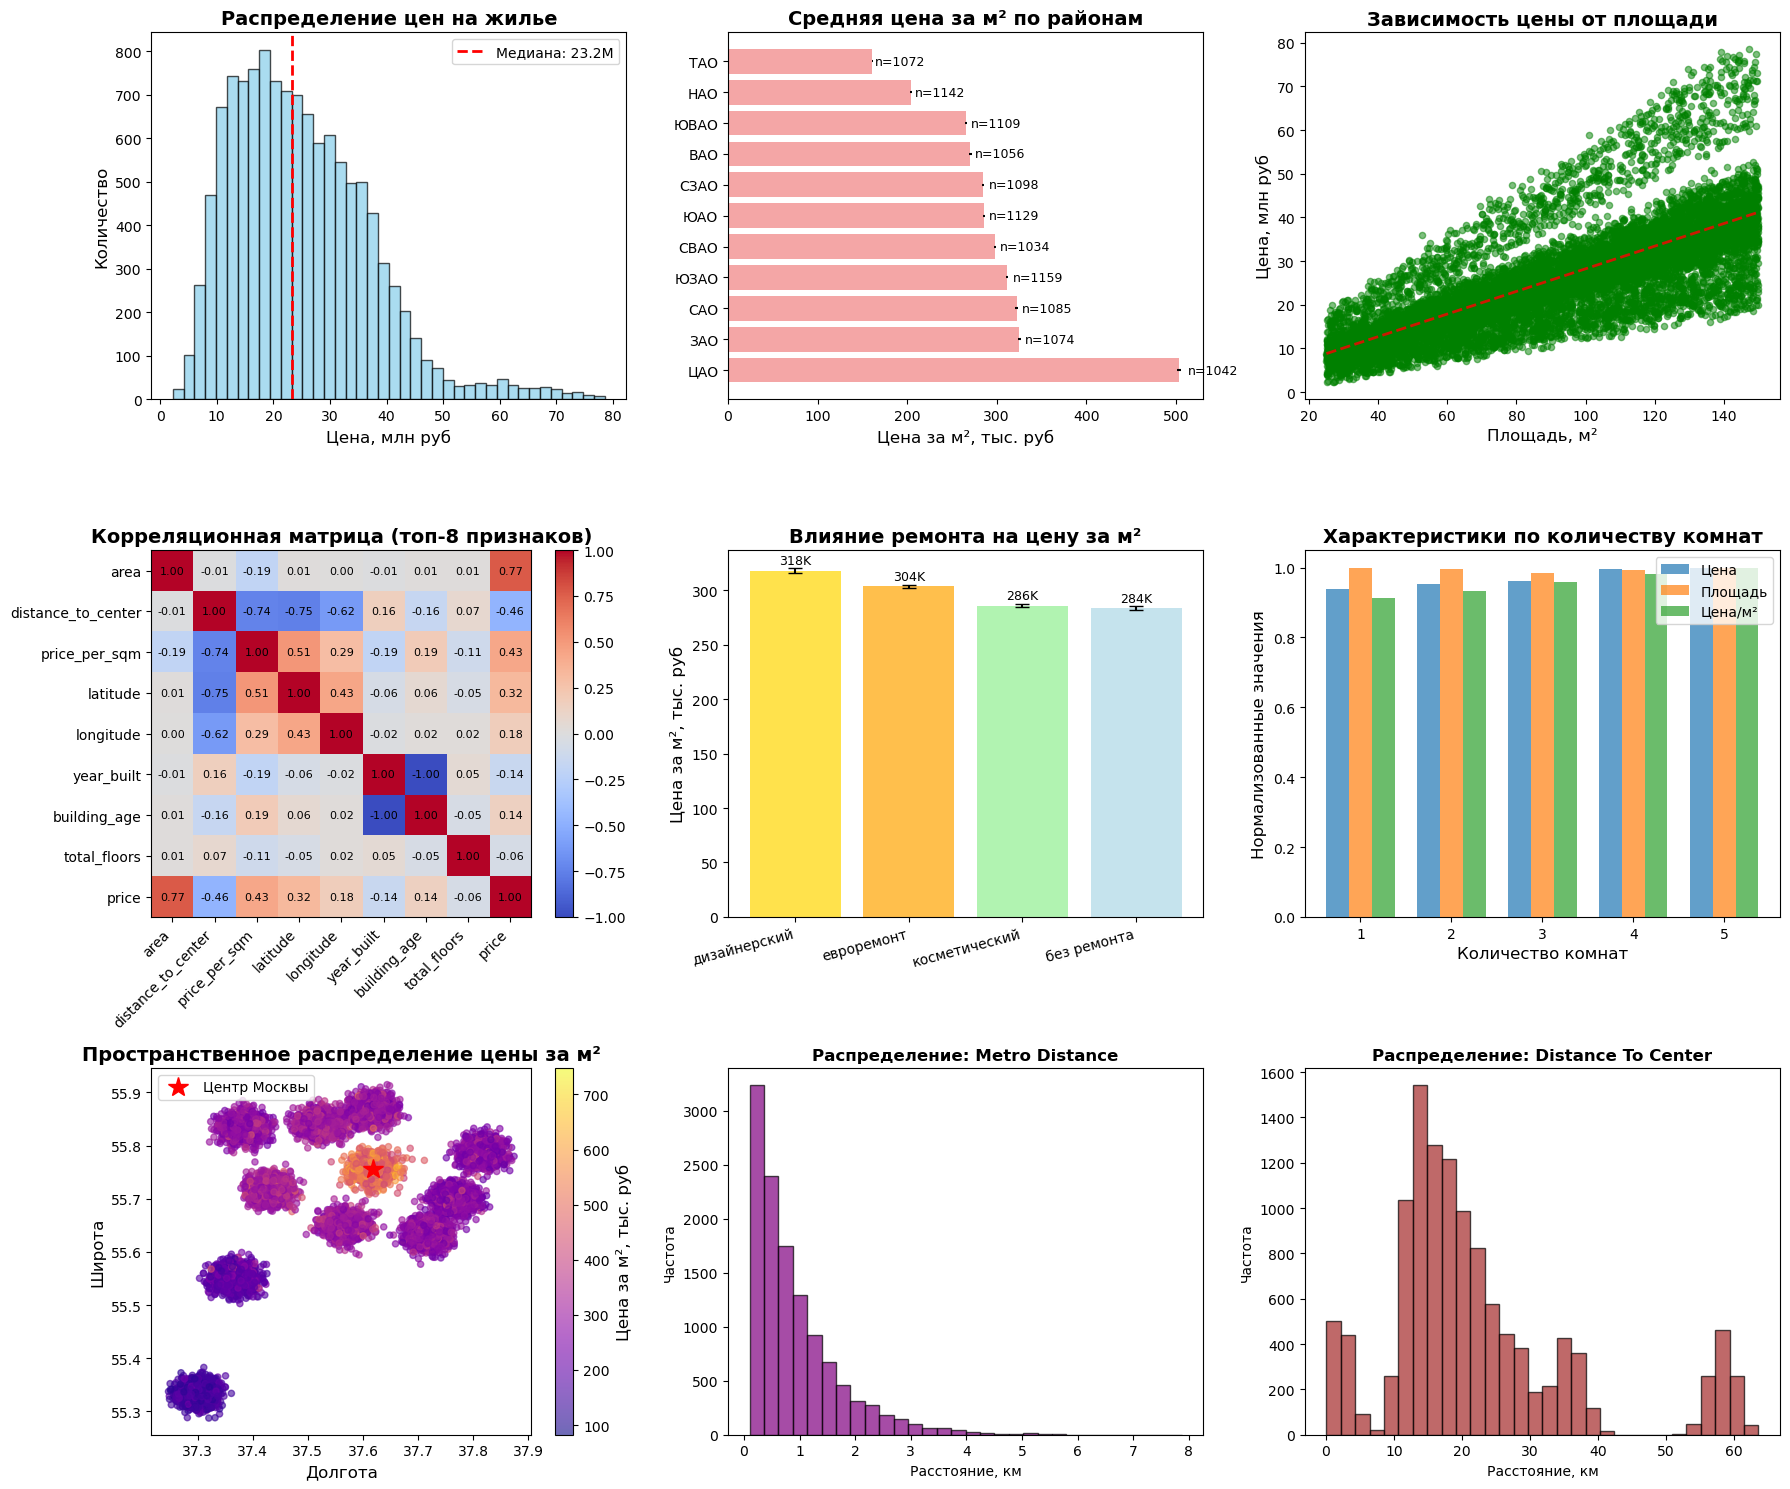


КЛЮЧЕВАЯ СТАТИСТИКА:

Общая статистика цен:
• Средняя цена: 24.91 млн руб
• Медианная цена: 23.21 млн руб
• Минимальная цена: 2.23 млн руб
• Максимальная цена: 78.55 млн руб
• Стандартное отклонение: 12.21 млн руб

Статистика цены за м²:
• Средняя цена за м²: 293.0 тыс. руб
• Медианная цена за м²: 283.9 тыс. руб

Районы с самой высокой и низкой ценой за м²:
• Самый дорогой: ЦАО - 503.6 тыс. руб/м²
• Самый доступный: ТАО - 161.2 тыс. руб/м²

Топ-5 признаков по корреляции с ценой:
1. area: 0.766
2. distance_to_center: 0.463
3. price_per_sqm: 0.426
4. latitude: 0.323
5. longitude: 0.179

3. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ
----------------------------------------

ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ
Категориальные признаки (3): ['district', 'building_type', 'renovation']
Числовые признаки (18): ['latitude', 'longitude', 'area', 'rooms', 'floor', 'total_floors', 'metro_distance', 'distance_to_center', 'park_distance', 'school_distance', 'shopping_distance', 'year_built', 'building_age'

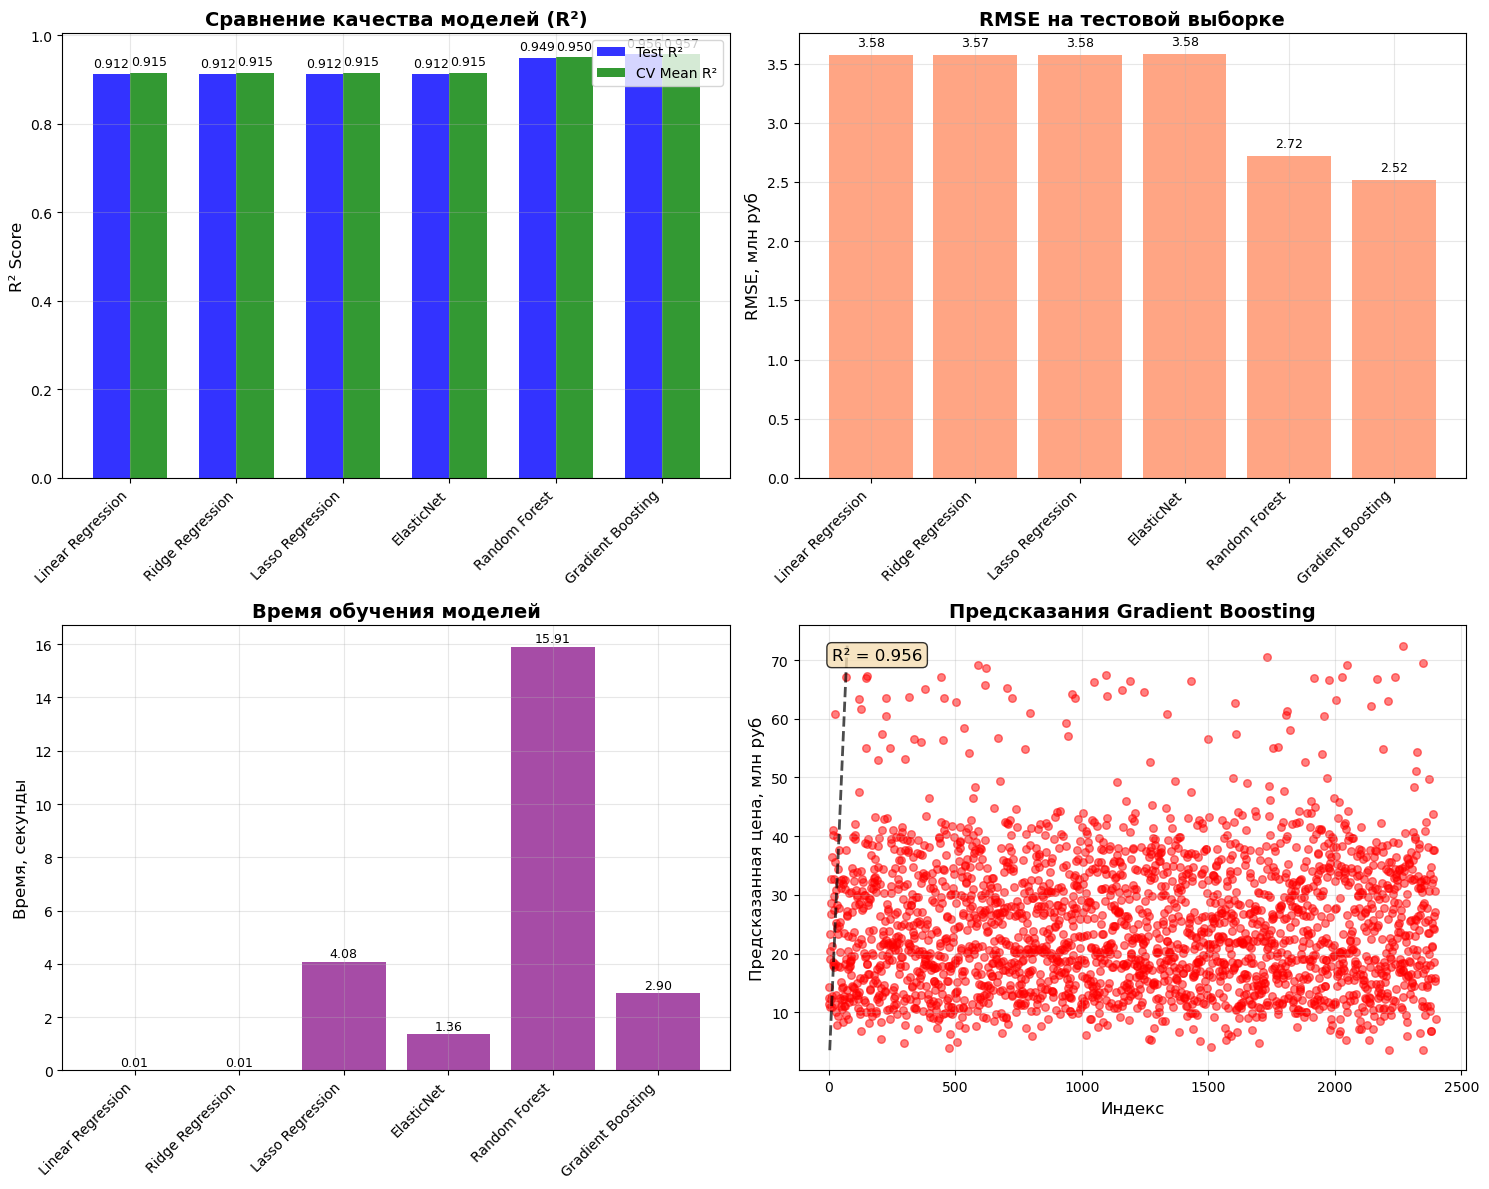


ЛУЧШАЯ МОДЕЛЬ:
Модель: Gradient Boosting
R² на тесте: 0.9564
RMSE на тесте: 2.518 млн руб
MAE на тесте: 1.988 млн руб

5. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
----------------------------------------

АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ (Random Forest)

Топ-15 наиболее важных признаков:
--------------------------------------------------
area                                     0.3689
area_squared                             0.2380
district_ЦАО                             0.2089
latitude                                 0.0995
longitude                                0.0163
distance_to_center_squared               0.0150
distance_to_center                       0.0137
area_per_room                            0.0037
school_distance                          0.0031
shopping_distance                        0.0031
ceiling_height                           0.0030
park_distance                            0.0030
total_accessibility                      0.0025
metro_distance                           0.0024
total_flo

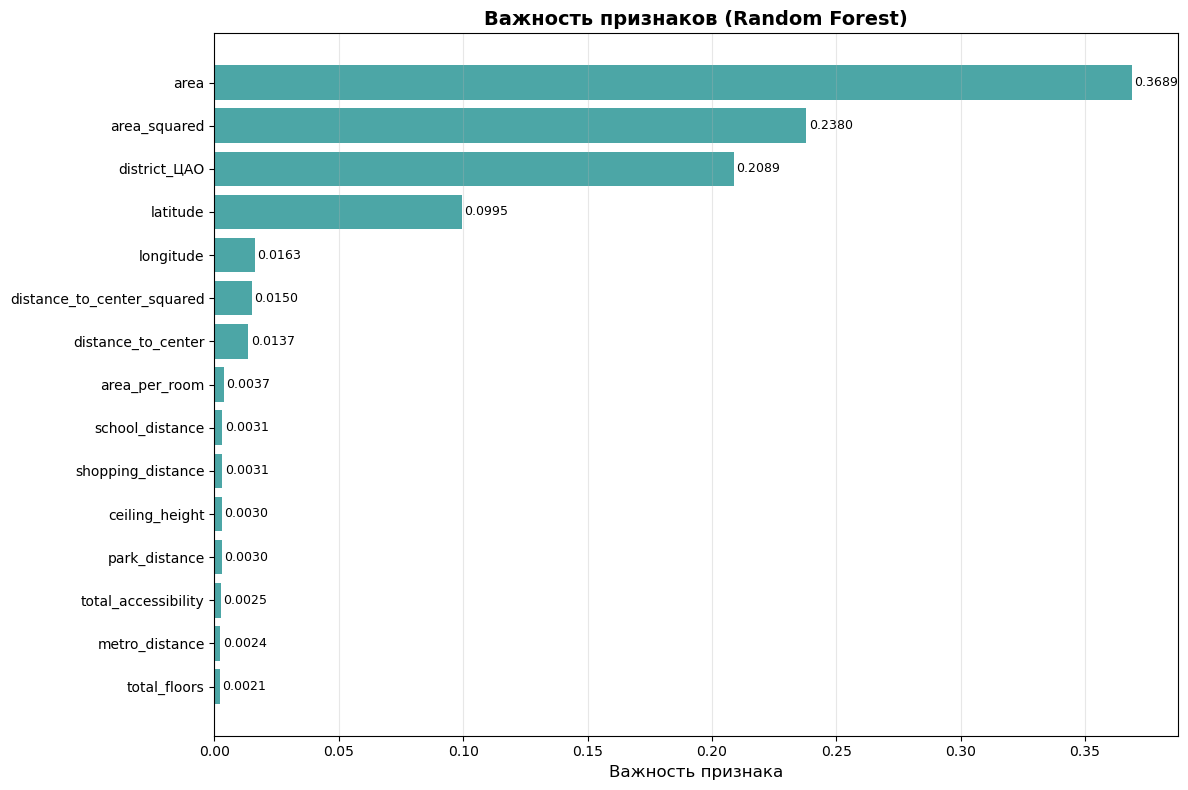


6. БИЗНЕС-АНАЛИТИКА
----------------------------------------

БИЗНЕС-ИНСАЙТЫ И РЕКОМЕНДАЦИИ
• 1. Разброс цен между районами: ЦАО дороже ТАО в 3.1 раз
• 2. дизайнерский увеличивает стоимость на 12% относительно без ремонта
• 3. Квартиры в радиусе 5 км от центра дороже на 84%
• 4. Большие квартиры имеют меньшую стоимость за м² (корреляция: -0.19)

----------------------------------------------------------------------
РЕКОМЕНДАЦИИ:
----------------------------------------------------------------------
1. Для инвесторов: сфокусируйтесь на квартирах в ЦАО с потенциалом ремонта
2. Для застройщиков: стройте в районах с развитой инфраструктурой ближе к метро
3. Для продавцов: инвестируйте в качественный ремонт перед продажей
4. Для покупателей: рассматривайте квартиры на высоких этажах (кроме последнего)
5. Для аналитиков: учитывайте временные тренды и сезонность рынка
6. Для агентств: развивайте компетенции в оценке премиальных характеристик

7. ПРИМЕР ПРОГНОЗИРОВАНИЯ
-----------------------

In [18]:
# Основной скрипт
def main():
    print("=" * 80)
    print("АНАЛИЗ РЫНКА НЕДВИЖИМОСТИ МОСКВЫ: ПРОСТРАНСТВЕННАЯ РЕГРЕССИЯ")
    print("=" * 80)
    
    # Шаг 1: Создание или загрузка данных
    print("\n1. ПОДГОТОВКА ДАННЫХ")
    print("-" * 40)
    
    # Создаем реалистичные синтетические данные
    data = create_realistic_moscow_data(12000)
    print(f"Создано {len(data)} записей о квартирах в Москве")
    
    # Шаг 2: Инициализация анализатора
    analyzer = MoscowHousingRegression(data)
    
    # Шаг 3: Разведочный анализ
    print("\n2. РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ")
    print("-" * 40)
    analyzer.exploratory_data_analysis()
    
    # Шаг 4: Подготовка данных для моделирования
    print("\n3. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ")
    print("-" * 40)
    X_train, X_test, y_train, y_test, feature_names = analyzer.prepare_features_for_modeling()
    
    if X_train is None:
        print("Ошибка при подготовке данных. Завершение работы.")
        return
    
    # Шаг 5: Обучение и оценка моделей
    print("\n4. МОДЕЛИРОВАНИЕ И ОЦЕНКА")
    print("-" * 40)
    results = analyzer.train_and_evaluate_models(X_train, X_test, y_train, y_test)
    
    # Шаг 6: Анализ важности признаков
    print("\n5. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
    print("-" * 40)
    feature_importance = analyzer.analyze_feature_importance('Random Forest', feature_names)
    
    # Шаг 7: Генерация инсайтов
    print("\n6. БИЗНЕС-АНАЛИТИКА")
    print("-" * 40)
    analyzer.generate_business_insights()
    
    # Шаг 8: Пример прогноза
    print("\n7. ПРИМЕР ПРОГНОЗИРОВАНИЯ")
    print("-" * 40)
    analyzer.predict_new_sample({
        'district': 'ЦАО',
        'area': 75.3,
        'rooms': 3,
        'floor': 12,
        'total_floors': 20,
        'metro_distance': 0.5,
        'distance_to_center': 2.1,
        'renovation': 'евроремонт',
        'building_type': 'монолит'
    })
    
    # Сохранение результатов
    try:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Сохраняем данные
        data.to_csv(f'moscow_housing_data_{timestamp}.csv', index=False, encoding='utf-8-sig')
        print(f"\nДанные сохранены в файл: moscow_housing_data_{timestamp}.csv")
        
        # Сохраняем важность признаков
        if feature_importance is not None:
            feature_importance.to_csv(f'feature_importance_{timestamp}.csv', index=False, encoding='utf-8-sig')
            print(f"Важность признаков сохранена в файл: feature_importance_{timestamp}.csv")
        
        # Сохраняем метрики моделей
        if analyzer.results:
            metrics_df = pd.DataFrame({
                'Model': list(analyzer.results.keys()),
                'Test_R2': [r['test_r2'] if r else None for r in analyzer.results.values()],
                'Test_RMSE': [r['test_rmse']/1e6 if r else None for r in analyzer.results.values()],
                'CV_Mean_R2': [r['cv_mean'] if r else None for r in analyzer.results.values()],
                'Training_Time': [r['training_time'] if r else None for r in analyzer.results.values()]
            })
            metrics_df.to_csv(f'model_metrics_{timestamp}.csv', index=False, encoding='utf-8-sig')
            print(f"Метрики моделей сохранены в файл: model_metrics_{timestamp}.csv")
            
    except Exception as e:
        print(f"\nОшибка при сохранении файлов: {e}")
    
    print("\n" + "=" * 80)
    print("АНАЛИЗ УСПЕШНО ЗАВЕРШЕН!")
    print("=" * 80)
    
if __name__ == "__main__":
    main()